<a href="https://colab.research.google.com/github/mrpiay/mrbeam/blob/main/mrbeam_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step #1: install mrbeam framework**

In [1]:
! git clone https://github.com/mrpiay/mrbeam.git

Cloning into 'mrbeam'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 606 (delta 36), reused 0 (delta 0), pack-reused 538
Receiving objects: 100% (606/606), 57.44 MiB | 28.04 MiB/s, done.
Resolving deltas: 100% (257/257), done.


In [ ]:
! wget https://github.com/liamedeiros/ehtplot/archive/refs/heads/master.zip
! unzip master.zip -d .
! wget https://github.com/achael/eht-imaging/archive/refs/tags/v1.2.7.zip
! unzip v1.2.7.zip -d .
! pip install pygmo
! pip install ./ehtplot-master
! pip install ./eht-imaging-1.2.7
! pip install ./mrbeam/mr_beam/itreg
! pip install ./mrbeam/mr_beam/libwise-0.4.7-light
! pip install ./mrbeam/mr_beam/MSI
! pip install ./mrbeam/mr_beam/imagingbase
! pip install ./mrbeam/mr_beam/ga

# **Step #2: restart session (Runtime -> Restart session (Ctrl+M) )**





# **Javier Example**

In [25]:
import pygmo as pg
import numpy as np
import GA.solver as solver
from GA.problems import EHT
import sys
import ehtim as eh
import matplotlib.pyplot as plt

#mrpiay
import json
import pprint
#mrpiay

In [ ]:
#config_file = './mrbeam/mr_beam/mrpiay/ring_16_first_test.config'
outfile = './mrbeam/mr_beam/mrpiay/logger.log'

#mrpiay
config_file = './mrbeam/mr_beam/mrpiay/ring_16_first_test.config.json'
#mrpiay

In [3]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters. WE WON'T USE THEM FOR NOW
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 3                 # Total compact flux density (Jy)
npix      = 16                # Number of pixels across the reconstructed image
fov       = 160*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities

#data weights
data_term = {'amp'    : 1.0,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-4                # Imager stopping criterion
gain_tol  = [0.02,0.2,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['ALMA', 'APEX']    # baseline to measure zero-spacing flux
#rescaling = 0.04              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 1.6*10**11]       #cbar-lims for interactive plotting (brightness temperature)

In [ ]:
# Way of reading the config_file... if json is done, don't needed

# IMPORTANT!: Remember to change the path of img and uvf in your config

#config = solver.read_config_params(config_file, 'EHT')

#mrpiay
def create_config_json():
  print(json.dumps(config, indent = 4))
#create_config_json()
#mrpiay

{
    "reg_term": {
        "l1w": 1.0,
        "simple": 0.1,
        "tv": 10.0,
        "tv2": 10.0,
        "lA": 10.0,
        "flux": 10000.0
    },
    "data_term": {
        "vis": 1.0,
        "amp": 0.0,
        "cphase": 0.0,
        "logcamp": 0.0
    },
    "img": "/content/mrbeam/mr_beam/mrpiay/ring_16.fits",
    "uvf": "/content/mrbeam/mr_beam/mrpiay/ring_16.uvfits",
    "rescaling": 0.02,
    "zbl": 0.6,
    "grid_size": 7,
    "seed_initial": 12,
    "prior_fwhm": 100.0,
    "num_cores": 64,
    "generations": 10,
    "neighbours": 6,
    "decomposition_method": "grid",
    "decomposition_seed": 12,
    "CR": 1.0,
    "F": 0.5,
    "eta_m": 20.0,
    "realb": 0.9,
    "limit": 2,
    "preserve_diversity": true,
    "pop_size": 1716,
    "mode": "pareto"
} 

Loading uvfits:  /content/mrbeam/mr_beam/mrpiay/ring_16.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  /content/mrbeam/mr_beam

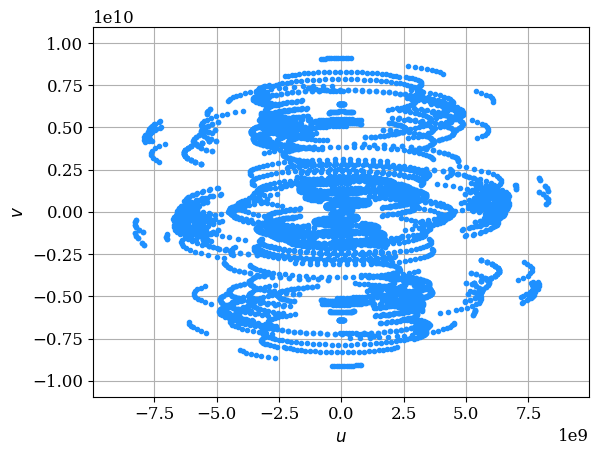


Plot visibility amplitudes, phases, etc. as a function of uv distance


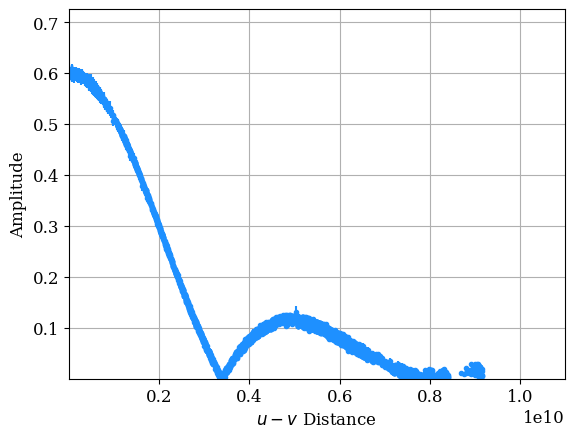


Plot prior


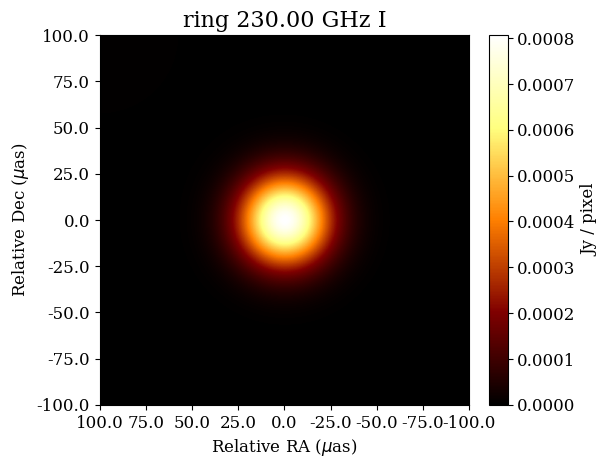


Plot true_img


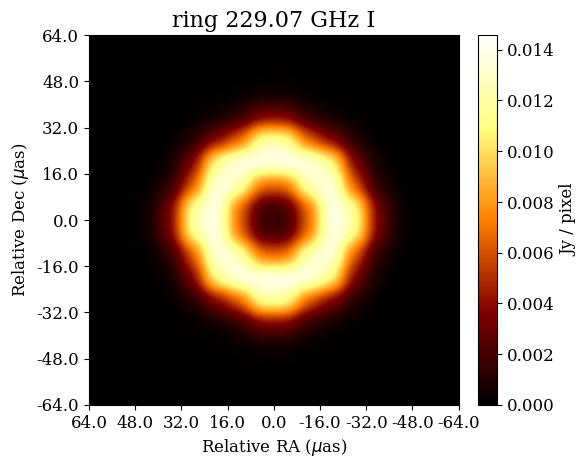


Dirty beam


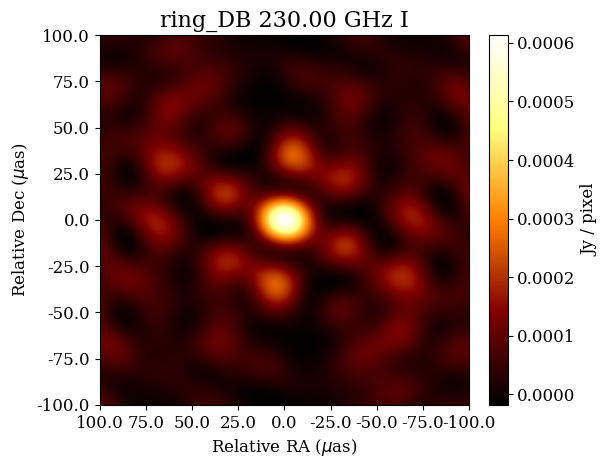


Clean beam


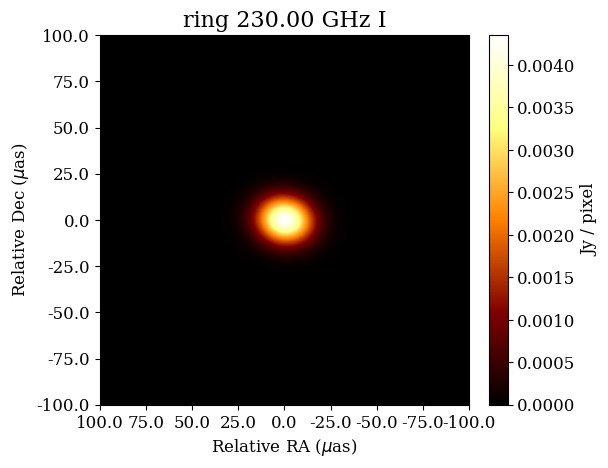


Dirty image


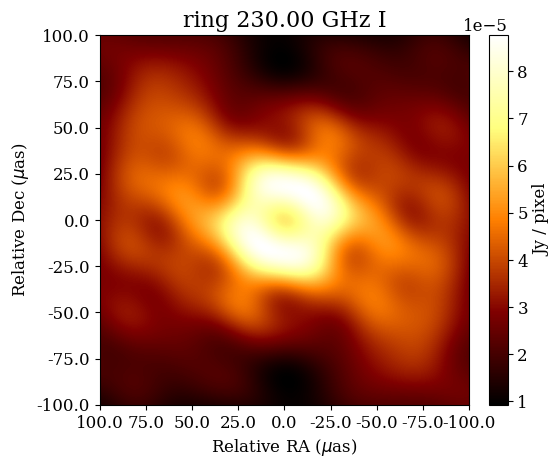

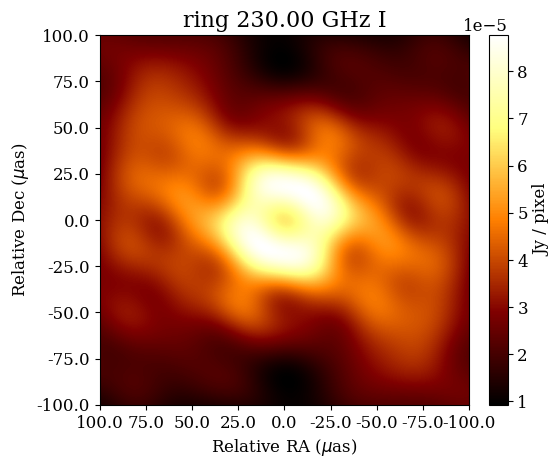

In [78]:
# Prior definition for the entropy regularizer

#obs = eh.obsdata.load_uvfits(config['uvf'])

#mrpiay
with open(config_file) as f:
    config = json.load(f)
print(json.dumps(config, indent=4),'\n')
#mrpiay

obs = eh.obsdata.load_uvfits(config['uvf'])
true_img = eh.image.load_fits(config['img'])
obs_sc = obs.copy()

prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
prior = prior.add_gauss(1e-2*zbl, (100*eh.RADPERUAS, 100*eh.RADPERUAS, 0, 100*eh.RADPERUAS, 100*eh.RADPERUAS))

#mrpiay
# Plot uv-coverage
print('\nPlot uv-coverage')
obs.plotall('u', 'v', conj=True)
# Plot visibility amplitudes, phases, etc. as a function of uv distance
print('\nPlot visibility amplitudes, phases, etc. as a function of uv distance')
obs.plotall('uvdist', 'amp')
print('\nPlot prior')
prior.display()
print('\nPlot true_img')
true_img.display()


npix = 128
fov = 200*eh.RADPERUAS
dbeam = obs.dirtybeam(npix, fov)
print('\nDirty beam')
dbeam.display()
cbeam = obs.cleanbeam(npix,fov)
print('\nClean beam')
cbeam.display()
dim = obs.dirtyimage(npix, fov)
print('\nDirty image')
dim.display()

#mrpiay

In [79]:
#mrpiay
print('\ntrue_img:\n')
print(vars(true_img))
print('\nprior:\n')
print(vars(prior))
print('\nobs:\n')
print(vars(obs))
#mrpiay


obs:

{'polrep': 'stokes', 'poldict': {'vis1': 'vis', 'vis2': 'qvis', 'vis3': 'uvis', 'vis4': 'vvis', 'sigma1': 'sigma', 'sigma2': 'qsigma', 'sigma3': 'usigma', 'sigma4': 'vsigma'}, 'poltype': [('time', 'f8'), ('tint', 'f8'), ('t1', 'U32'), ('t2', 'U32'), ('tau1', 'f8'), ('tau2', 'f8'), ('u', 'f8'), ('v', 'f8'), ('vis', 'c16'), ('qvis', 'c16'), ('uvis', 'c16'), ('vvis', 'c16'), ('sigma', 'f8'), ('qsigma', 'f8'), ('usigma', 'f8'), ('vsigma', 'f8')], 'source': 'ring', 'ra': 12.5137287222, 'dec': 12.391123306, 'rf': 230000000000.0, 'bw': 8000000000.0, 'ampcal': True, 'phasecal': True, 'opacitycal': True, 'dcal': True, 'frcal': True, 'timetype': 'UTC', 'data': array([(1.38902664e-03, 0., 'AA', 'AP', 0.12      , 0.12      ,  8.72307500e+05, -1.77677100e+06,  0.60018688-1.42261659e-04j,  1.26706655e-05-1.13581933e-04j, -2.40963709e-05+4.34944195e-05j, -5.29289246e-05-8.54884747e-05j, 0.01200422, 0.01200422, 0.01200422, 0.01200422),
       (1.38902664e-03, 0., 'AA', 'CI', 0.12      , 0.31999

In [19]:
# Getting the inputs

reg_term = config['reg_term']
data_term = config['data_term']
rescaling = config['rescaling']
zbl = config['zbl']

In [20]:
# Now, we create the MOP

EHTfit = EHT.EHT(obs, prior, data_term, reg_term, rescaling, zbl, npix**2)
EHTfit.setFit()

udp = pg.problem(EHTfit)

Generating I image...
Generating I image...
Generating I image...
Generating I image...
Generating I image...
Generating I image...
Generating I image...


In [21]:
#mrpiay
from pprint import pprint;
print('EHT:')
pprint(vars(EHTfit))
print('\nEHT.fit:')
pprint(vars(EHTfit.fit))
print('\nUDP:')
print(udp)
#for i in list(vars(EHTfit.fit).keys()):
#  if 'fid' in i:
#    pprint(vars(getattr(EHTfit.fit, i)))

EHT:
{'data_term': {'amp': 0.0, 'cphase': 0.0, 'logcamp': 0.0, 'vis': 1.0},
 'dim': 256,
 'fit': <GA.problems.EHT.MyFunc object at 0x7880ee88e3b0>,
 'mode': 'pareto',
 'num_cores': 16,
 'obs': <ehtim.obsdata.Obsdata object at 0x7880ee88d870>,
 'prior': <ehtim.image.Image object at 0x7880ee88e6b0>,
 'reg_term': {'flux': 10000.0,
              'l1w': 1.0,
              'lA': 10.0,
              'simple': 0.1,
              'tv': 10.0,
              'tv2': 10.0},
 'rescaling': 0.02,
 'zbl': 0.6}

EHT.fit:
{'data_fidelity_term': <regpy.functionals.Composed object at 0x7880ee88e770>,
 'func_amp': <imagingbase.ehtim_wrapper.EmptyFunctional object at 0x7880ee88f670>,
 'func_cph': <imagingbase.ehtim_wrapper.EmptyFunctional object at 0x7880ee88ff70>,
 'func_flux': <imagingbase.ehtim_wrapper.EhtimFunctional object at 0x7880ee88f7f0>,
 'func_l1': <imagingbase.ehtim_wrapper.EhtimFunctional object at 0x7880ee88f0a0>,
 'func_l2': <imagingbase.ehtim_wrapper.EhtimFunctional object at 0x7880ee88f730>,


In [ ]:
# Defining MOEA/D

def calculate_pop_size(grid_size):
    x = np.arange(grid_size+1)
    return int(np.sum(np.sum(np.meshgrid(x, x, x, x, x, x, x, x), axis=0) == grid_size))
pop_size = 84 #924 #config['grid_size'] If you have supercomputer, use the config, otherwise use this
seed = config['seed_initial']
pop = pg.population(udp, size=pop_size, seed=seed)


weights = pg.decomposition_weights(n_f=udp.get_nf(), n_w=len(pop), method=config['decomposition_method'], seed=config['decomposition_seed'])

gen = config['generations']
neighbours = config['neighbours']

algo = pg.algorithm(pg.moead(gen=gen, neighbours=neighbours, decomposition="weighted", weight_generation=config["decomposition_method"], seed=config['decomposition_seed']))

algo.set_verbosity(1)

maxit = 10 #100
stop = 1e-4
uv_zblcut2 = 0.1*10**9
res = obs_sc.res()

# This is for chosing a good starting point for the opti problem. Try both options and check difference
for i in range(len(pop)):
    pop.set_x(i, np.concatenate([obs.dirtyimage(true_img.xdim, true_img.fovx()).imvec/rescaling])) #dirty image as starting point
    # pop.set_x(i, np.concatenate([prior.imvec/rescaling])) # Gaussian

In [ ]:
# Et voilà! evolve and getting the sol

pop = algo.evolve(pop)

fits, vectors = pop.get_f(), pop.get_x()

In [ ]:
# And print some random solutions

save = False

#randsel = [np.random.random_integers(1, len(vectors)-1) for i in range(100)]
randsel = [np.random.random_integers(1, len(vectors)-1) for i in range(1)]
im=eh.image.load_fits('./mrbeam/mr_beam/mrpiay/ring_16.fits')
#im=eh.image.load_fits('synthetic_data/models/ring_16.fits')
for i in randsel:
   im.imvec = vectors[i]*rescaling
   im.display() #for saving im.display(export_pdf='path/name.png/pdf')
if save:
   import os
   os.system('rm %s_vectors*' % outfile)
   np.savetxt(outfile+'_fits.npy',fits)
   np.savetxt(outfile+'_vectors.npy',vectors)
   np.savetxt(outfile+'_weights.npy',weights)